In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# Chemin vers le fichier CSV
fichier_csv = 'Stage-3.csv'

# Chargement du fichier CSV dans un DataFrame
df = pd.read_csv(fichier_csv)

# Afficher les 5 premières lignes
print(df)

    Numéro  Position  Pression (Torr)  Ch. Magnétique (T) Gaz
0       33       0.0              0.0                 0.0  N2
1       34       1.4              5.0                 0.0  N2
2       35       2.0              5.0                 0.0  N2
3       36       2.6              5.0                 0.0  N2
4       37       1.4              5.0                 1.5  N2
5       38       2.0              5.0                 1.5  N2
6       39       2.6              5.0                 1.5  N2
7       41       1.4              1.0                 0.0  N2
8       42       2.0              1.0                 0.0  N2
9       43       2.6              1.0                 0.0  N2
10      44       1.4              1.0                 2.0  N2
11      45       2.0              1.0                 2.0  N2
12      46       2.6              1.0                 2.0  N2
13      47       1.4              1.0                 2.0  N2
14      48       2.0              1.0                 2.0  N2
15      

In [10]:
def load_image(file_path):
    # This two lines will let you open a .tif file as a np matrix.
    # The matrix will have a value of "intensity" in each cell, while .tif file usually contains 
    # more data associated to the camera that acquired the image, but I am no expert on this.
    # For the moment, we only care about the intensity color map 
    img = Image.open(file_path)
    img_data = np.array(img)
    return img_data

FLIP = True

ligne_num = int(input())
if ligne_num >= 16 :
    FLIP = False
ligne = df.iloc[ligne_num]

position = ligne['Position']
numero = int(ligne['Numéro'])
gaz = ligne['Gaz']

 7


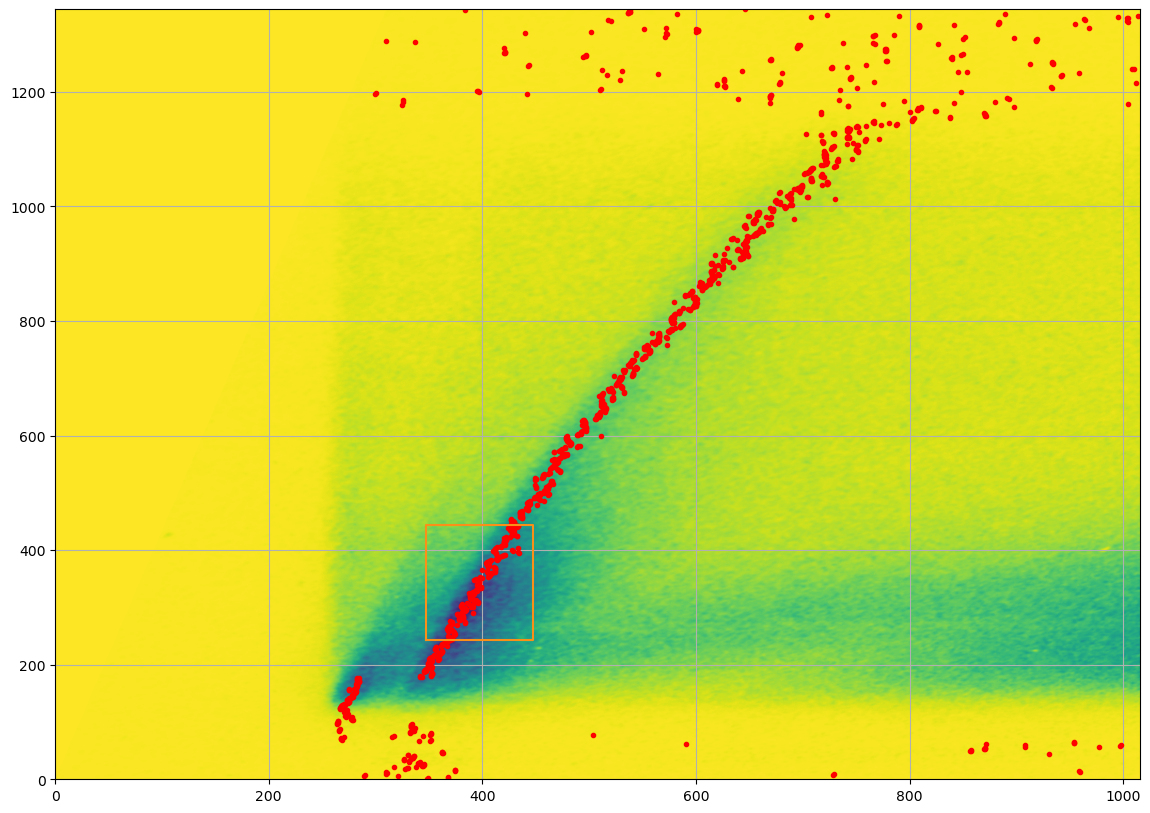

In [11]:
file_path =  f"../Stage_Pic/477{numero}.tif"

# Valeurs données
ti = -26.67  # ns
tf = 73.1    # ns

# Définition des valeurs de xi, xf selon la position
if position == 1.4:
    xi, xf = 0.3, 2.6
elif position == 2:
    xi, xf = 0.9, 3.32
elif position == 2.6:
    xi, xf = 1.5, 3.9
else:
    xi, xf = None, None
    
if gaz == 'N2' :
    M = 336.96
elif gaz == 'He' :
    M = 1020
else :
    M = 0

img_data = load_image(file_path)        # Load the image with function as a matrix
if FLIP == True : 
    img_data = np.flip(img_data, axis = 0)  # Some image will need flipping, some others no.

x = np.linspace(0,1344,1344) # pixels horizontaux

P_max = [] # liste des maximums
L_max = []
m = 0
px0, py0 = 0, 0

for ligne in img_data : 
    P_max.append(np.where(ligne == max(ligne))[0][0]) # cherche les maximums de chaque ligne
    
for i in range(len(img_data)) :
    if max(img_data[i]) > m :
        m = max(img_data[i])
        py0 = i
px0 = np.where(img_data[py0] == max(img_data[py0]))[0][0]

    
pxmin = px0 - 50
pxmax = px0 + 50
pymin = 1344 - py0 - 100
pymax = 1344 - py0 + 100
    
pts = np.array(P_max)

px = np.array([pxmin,pxmax,pxmax,pxmin,pxmin])
py = np.array([pymin,pymin,pymax,pymax,pymin])

def fitlin(x, a, b) :
    return a * x + b

p1, var1 = curve_fit(fitlin, np.flip(pts)[pymin:pymax], x[pymin:pymax])
a1, b1 = p1


# Tracer l'image
plt.figure(figsize=(14, 10))
plt.imshow(img_data,                   # Affichage 2D de l'image
           cmap='viridis_r',           # Colormap
           extent=[0, 1016, 0, 1344],
           aspect='auto',              # Ratio automatique
           vmax=np.max(img_data)) # Réglage de la luminosité maximale
plt.grid()
plt.plot(np.flip(pts), x, '.', color = '#ff0000')
plt.plot(px, py, color = '#fa9017')
plt.show()

In [12]:
"""def filtre(L) : # servirais hypothétiquement à filtré les points bruités et/ou mesures imprécises
    vi,vf,v = 0,0,0
    for i in range(0,len(L)-1) :
        if np.abs(L[i+1] - L[i]) < 10 :
            v += 1
            if v == 10 :
                vi = i - 10
                break
        if np.abs(L[i+1] - L[i]) > 10 :
            v = 0
            
    for i in range(vi,len(L)-1) :
        if np.abs(L[i+1] - L[i]) < 20 :
            v = 0
        if np.abs(L[i+1] - L[i]) > 20 :
            v += 1
            if v == 5 :
                vf = i - 5
                break
                
    return vi,vf"""


vi, vf = int(input()), int(input()) # tronque les mesures imprécises
x_filtre = x[vi:vf] # x filtré sans le bruit
pts_filtre = np.flip(pts)[vi:vf] # points filtrés sans le bruit

 200
 1000


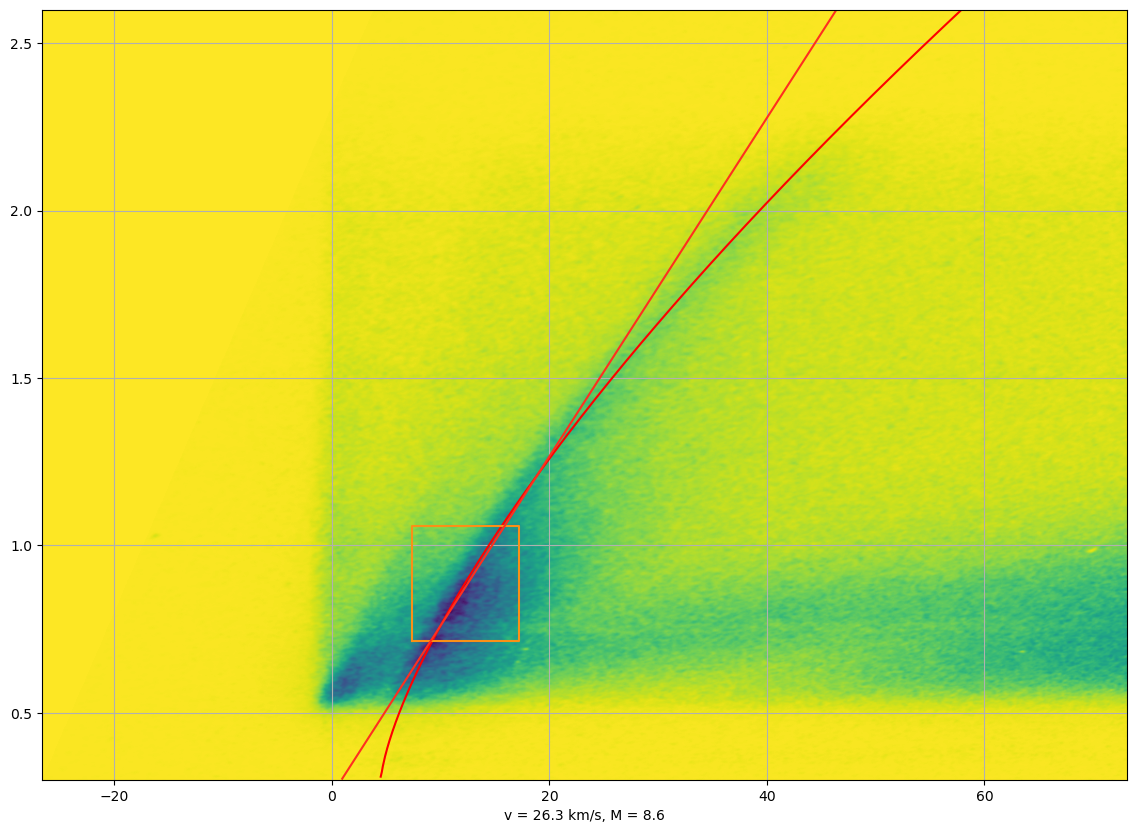

In [13]:
def fitpow(x, a, b, x0) :  # fit puissance
    return a * np.abs(x-x0) ** b

p0, var0 = curve_fit(fitpow, pts_filtre, x_filtre, maxfev = 100000)
a0, b0, x0 = p0

t_fin = np.linspace(0,1016,1016) # tableau des x final
x_pow = fitpow(t_fin, a0, b0, x0) # tableau des x fittés en puissance
x_lin = fitlin(t_fin, a1, b1) # tableau des x fittés en linéaire

ip, jp = 0,0
while x_pow[ip] > x_pow[ip+1] : # cherche le pic dans la courbe fit
    ip += 1
while x_pow[jp] <= 1344 : # enlève les possibles valeurs trop grandes
    jp += 1
    if jp == 1016 :
        break
        
il, jl = 0,0
while x_lin[il] < 0 : # cherche le pic dans la courbe fit
    il += 1
while x_lin[jl] <= 1344 : # enlève les possibles valeurs trop grandes
    jl += 1
    if jl == 1016 :
        break
        
def pix_to_t(t) :
    return (tf-ti) / 1016 * t + ti

def pix_to_x(x) :
    return (xf-xi) / 1344 * x + xi

t_convert_p = pix_to_t(t_fin[ip:jp])
t_convert_l = pix_to_t(t_fin[il:jl])
x_convertpow = pix_to_x(x_pow[ip:jp])
x_convertlin = pix_to_x(x_lin[il:jl])

plt.figure(figsize=(14, 10))
plt.imshow(img_data,                   # Affichage 2D de l'image
           cmap='viridis_r',           # Colormap
           extent=[ti, tf, xi, xf],
           aspect='auto',              # Ratio automatique
           vmax=np.max(img_data)) # Réglage de la luminosité maximale
plt.grid()
plt.plot(t_convert_p, x_convertpow, color = '#ff0000')
plt.plot(pix_to_t(px), pix_to_x(py), color = '#fa9017')
plt.plot(t_convert_l, x_convertlin, color = '#ff2f1f')

plt.xlabel('v = ' + str(np.abs(pix_to_t(a1)))[:4] + ' km/s, M = ' + str(np.abs(a1*1000/M))[:3])

plt.show()

# 